In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [104]:
from requirements import *
from utils.tl.state_transitions import *
from utils.tl.clinical_associations import *
from utils.pp.preprocess import preprocess
from utils.pl.plot_embedding import plot_embedding
from utils.pl.plot_overlaps import *
from scipy.cluster.hierarchy import leaves_list
from matplotlib.colors import LinearSegmentedColormap as lsc

## Import tumor AnnData

In [231]:
# Read in KG146 tumor data for mapping
filepath = f'{data_dir}/h5ads/Tumor.h5ad'
ad_tum = sc.read_h5ad(filepath, backed=False)

## Figure 1b. Hotspot local correlation matrix

In [8]:
# Read in HotSpot object
filepath = f'{data_dir}/other/hotspot.p'
hs_tum = pickle.load(open(filepath, 'rb'))

Alternatively, you can produce this object using the HotSpot package.

Although we used v0.9.0, the latest version can be run dirctly on AnnData objects, for example:

```
ad = ad[:, hs.counts.index] # Subset to HVGs and relevant genesets
hs = hotspot.Hotspot(
    ad_tum,
    layer_key='raw',
    model='danb',
    latent_obsm_key='X_pca',
    umi_counts_obs_key='total_counts'
)
hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs.compute_autocorrelations()

```

More information can be found here: https://hotspot.readthedocs.io/en/latest/

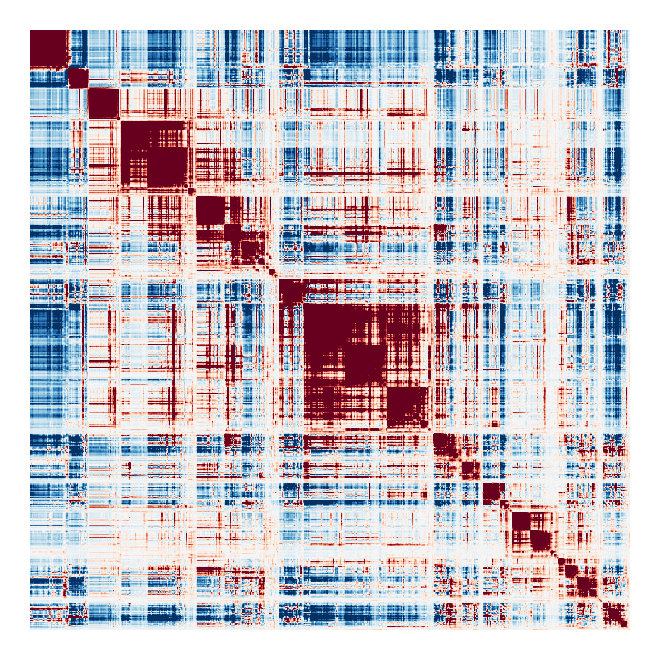

In [23]:
gs_kw = dict(bottom=0, top=1, left=0, right=1)
fig, ax = plt.subplots(1,1, figsize=(2,2), layout="tight", gridspec_kw=gs_kw)

# Plot Heatmap
row_order = leaves_list(hs_tum.linkage)
ax.imshow(
    hs_tum.local_correlation_z.iloc[row_order, row_order],
    vmin=-7.5, 
    vmax=7.5, 
    cmap="RdBu_r", 
    aspect="auto",
)
ax.axis("Off")
fig.patch.set_alpha(0)
fig.savefig(f'{media_dir}/figure_1b.svg')

## Figure 1c. Hotspot module cumulative fraction barplots

In [19]:
# Get HotSpot module names
filepath = f'{data_dir}/other/module_canonical_labels.csv'
labels = pd.read_csv(filepath, index_col=0)
ca_columns, nc_columns = labels.groupby('Label').apply(
    lambda x: list('Module ' + x.index + ' Score')
).loc[['Canonical', 'Non-Canonical']].values

In [126]:
# Filter to patients with sufficient cells per sample
sample_sizes = ad_tum.obs.groupby(['Patient', 'Sample Type']).size().unstack()
mask = ad_tum.obs['Patient'].map(sample_sizes.gt(10).all(1))
ad_tum = ad_tum[mask].copy()

In [224]:
# Get fractions per patient
groupby = 'Patient'
columns = (ca_columns + nc_columns)[::-1]
qtl_threshold = 0.75

thresholds = ad_tum.obs[columns].quantile(qtl_threshold)
module_counts = ad_tum.obs[columns].ge(thresholds).join(ad_tum.obs[groupby])
module_counts = module_counts.groupby(groupby, observed=True).sum()
fractions = module_counts.divide(
    df.groupby(groupby, observed=True, sort=False).size(),
    axis=0,
)
sort_order = fractions[nc_columns].sum(1).sort_values().index
fractions = fractions.loc[sort_order]

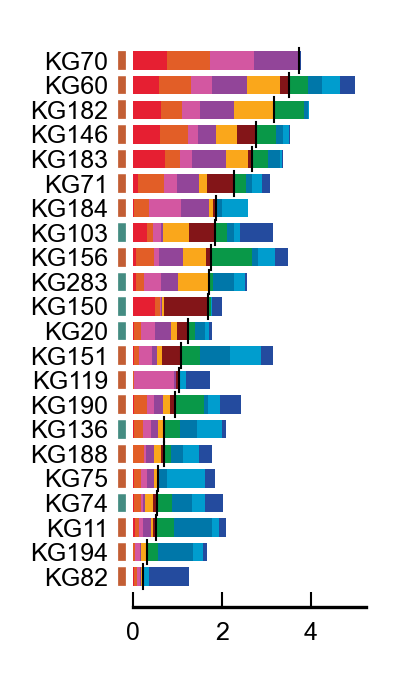

In [230]:
# Plot fractions
treatment = ad_tum.obs.groupby('Patient')['Treatment Status'].agg(pd.Series.mode)
row_colors = treatment.map(named_colors)
fractions.index = 'KG' + fractions.index.astype(str)
row_colors.index = 'KG' + row_colors.index.astype(str)

fig, ax = plt.subplots(1, 1, figsize=(1, 2.5))
plot_fractions(fractions, named_colors, ax, row_colors)
ax.tick_params(which='major', width=0.5)
fig.savefig(f'{media_dir}/figure_1c.svg')

## Figure 1d-e. Module log-ratio plots

### Non-Canonical modules

In [120]:
# Calculate log-ratios
groupby = ['Patient', 'Sample Type']
features = ca_columns + nc_columns
df = ad_tum.obs[groupby + features].copy()
df['High'] = df[features].idxmax(1).isin(nc_columns)

r, p = test_ratios(df, groupby, 2000)
print(f'P-value: {p}')

100%|██████████| 2000/2000 [00:27<00:00, 73.62it/s]


P-value: 0.0015084143054660225


In [121]:
# Get colormap and sort order for both plots below
color_list = [named_colors['Primary'], [0.9]*3, named_colors['Metastasis']]
cmap = lsc.from_list('', color_list)

fracs = df.groupby(groupby).mean()['High']
ratios = fracs.xs('Metastasis', level=1) / fracs.xs('Primary', level=1)
ratios = ratios.sort_values()
sort_order = ratios.index

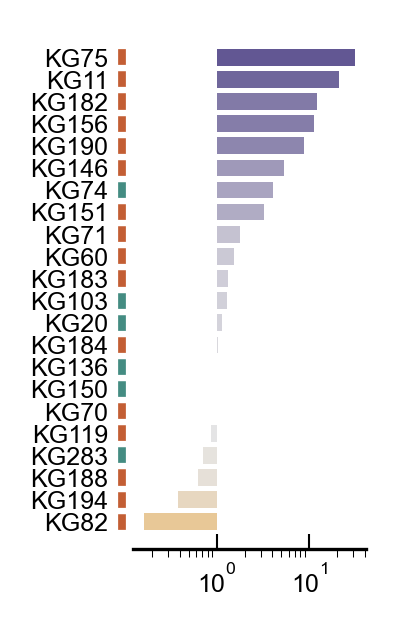

In [122]:
# Plot log-ratios
treatment = ad_tum.obs.groupby('Patient')['Treatment Status'].agg(pd.Series.mode)
row_colors = treatment.map(named_colors)
ratios.index = 'KG' + ratios.index.astype(str)
row_colors.index = 'KG' + row_colors.index.astype(str)

fig, ax = plt.subplots(1, 1, figsize=(1, 2.25))
plot_ratios(ratios, cmap, ax, row_colors)
ax.tick_params(which='minor', width=0.25)
ax.tick_params(which='major', width=0.5)
fig.savefig(f'{media_dir}/figure_1d.svg')

### Canonical modules

In [123]:
# Calculate log-ratios
groupby = ['Patient', 'Sample Type']
features = ca_columns + nc_columns
df = ad_tum.obs[groupby + features].copy()
df['High'] = df[features].idxmax(1).isin(ca_columns)

r, p = test_ratios(df, groupby, 2000)
print(f'P-value: {p}')

100%|██████████| 2000/2000 [00:27<00:00, 73.53it/s]


P-value: 0.9920966862905916


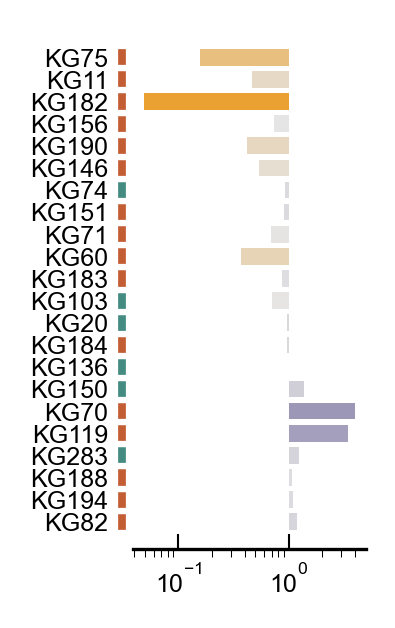

In [124]:
# Plot log-ratios
fracs = df.groupby(groupby).mean()['High']
ratios = fracs.xs('Metastasis', level=1) / fracs.xs('Primary', level=1)
ratios = ratios.loc[sort_order]
treatment = ad_tum.obs.groupby('Patient')['Treatment Status'].agg(pd.Series.mode)
row_colors = treatment.map(named_colors)
ratios.index = 'KG' + ratios.index.astype(str)
row_colors.index = 'KG' + row_colors.index.astype(str)

fig, ax = plt.subplots(1, 1, figsize=(1, 2.25))
plot_ratios(ratios, cmap, ax, row_colors)
ax.tick_params(which='minor', width=0.25)
ax.tick_params(which='major', width=0.5)
fig.savefig(f'{media_dir}/figure_1e.svg')

## Figure 1f-g. Module associations

### TCGA patients

In [27]:
enr_tcga = pd.read_csv(f'{data_dir}/other/TCGA_GSEA_enrichments.csv', index_col=0)
ann_tcga = pd.read_csv(f'{data_dir}/other/TCGA_annotations.csv', index_col=0)

In [28]:
tcga_binary_columns = dict(
    OS_STATUS=0,
    DFS_STATUS=0,
    NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT='NO',
    AJCC_PATHOLOGIC_TUMOR_STAGE=[
        'Stage I',
        'Stage IA',
        'Stage II',
        'Stage IIA',
        'Stage IIB',
        'Stage IIC',
        'Stage III',
        'Stage IIIA',
    ],
    RESIDUAL_TUMOR=['R0', 'RX'],
    PERINEURAL_INVASION='NO',
    LYMPHOVASCULAR_INVASION_INDICATOR='NO',
    AGE_lt_45=False,
    VASCULAR_INVASION_INDICATOR='NO',
    TREATMENT_OUTCOME_FIRST_COURSE=[
        'Complete Remission/Response',
        'Partial Remission/Response',
    ],
)

In [35]:
associations_tcga, pvals_tcga = get_associations(
    enr_tcga,
    ann_tcga,
    enr_tcga.columns,
    binary_columns=tcga_binary_columns,
    continuous_columns=[],
)

### LARC patients

In [36]:
enr_larc = pd.read_csv(f'{data_dir}/other/LARC_GSEA_enrichments.csv', index_col=0)
ann_larc = pd.read_csv(f'{data_dir}/other/LARC_annotations.csv', index_col=0)

In [37]:
associations_larc, pvals_larc = get_associations(
    enr_larc,
    ann_larc,
    enr_larc.columns,
    dict(distal_recurrence=0, OS_STATUS=0),
    continuous_columns=[],
)

### Recurrence Plot

In [145]:
# Recurrence
tcga_column = 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT'
larc_column = 'distal_recurrence'

df = pd.concat([
    associations_larc[larc_column],
    associations_tcga[tcga_column],
], axis=1)
df['module'] = df.index
df['label'] = df['module'].map(labels['Label'])

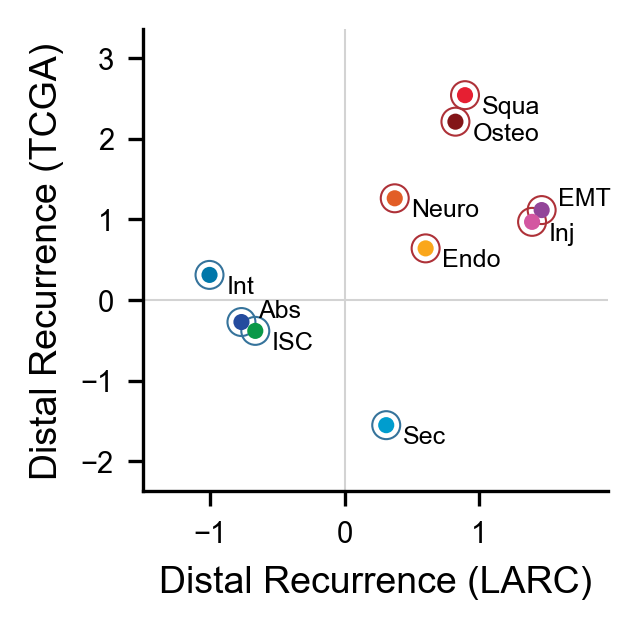

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

shared_kwargs = dict(data=df, x=larc_column, y=tcga_column, ax=ax, legend=False)

# Plot outlines
edge_colors = df['label'].map(named_colors)
styles = dict(s=45, lw=0.5, facecolor='none', edgecolor=edge_colors)
sns.scatterplot(**shared_kwargs, **styles)

# Plot centers
styles = dict(lw=0, s=15, palette=named_colors)
sns.scatterplot(**shared_kwargs, **styles, hue='module')

# Labels
for name, row in df.iterrows():
    styles = dict(size=6, va="top", ha="left")
    if name in ['EMT', 'Absorptive Intestine']: styles['va'] = 'bottom'
    ax.text(
        x=row[larc_column] + 0.125,
        y=row[tcga_column], 
        s=abbreviations[name],
        **styles
    )
ax.set_xlabel('Distal Recurrence (LARC)')
ax.set_ylabel('Distal Recurrence (TCGA)')

# Formatting
ax.margins(0.2, 0.2)
ax.axhline(0, lw=0.5, c='lightgray', zorder=-1)
ax.axvline(0, lw=0.5, c='lightgray', zorder=-1)
fig.savefig(f'{media_dir}/figure_1f.svg')

### Survival Plot

In [147]:
# Overall Survival
tcga_column = larc_column = 'OS_STATUS'
df = pd.concat([
    associations_larc[larc_column].rename('OS_STATUS_LARC'),
    associations_tcga[tcga_column].rename('OS_STATUS_TCGA'),
], axis=1)
tcga_column += '_TCGA'
larc_column += '_LARC'
df['module'] = df.index
df['label'] = df['module'].map(labels['Label'])

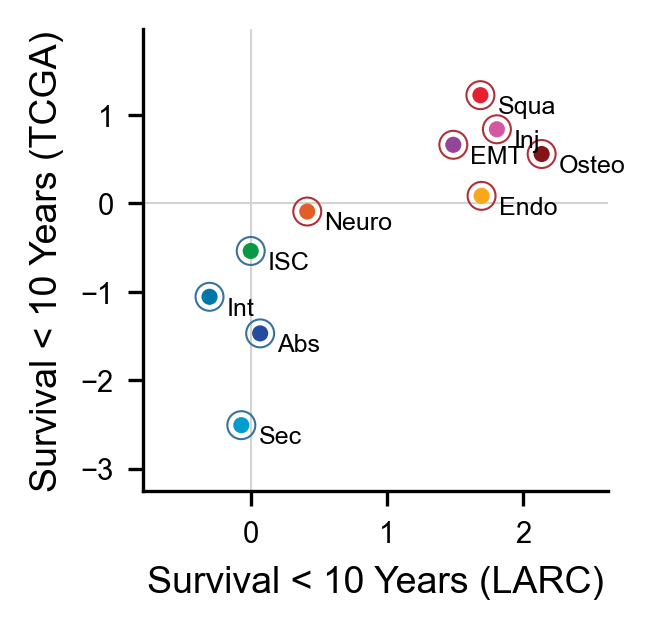

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

shared_kwargs = dict(data=df, x=larc_column, y=tcga_column, ax=ax, legend=False)

# Plot outlines
edge_colors = df['label'].map(named_colors)
styles = dict(s=45, lw=0.5, facecolor='none', edgecolor=edge_colors)
sns.scatterplot(**shared_kwargs, **styles)

# Plot centers
styles = dict(lw=0, s=15, palette=named_colors)
sns.scatterplot(**shared_kwargs, **styles, hue='module')

# Labels
for name, row in df.iterrows():
    styles = dict(size=6, va="top", ha="left")
    #if name in ['EMT', 'Absorptive Intestine']: styles['va'] = 'bottom'
    ax.text(
        x=row[larc_column] + 0.125,
        y=row[tcga_column], 
        s=abbreviations[name],
        **styles
    )
ax.set_xlabel('Survival < 10 Years (LARC)')
ax.set_ylabel('Survival < 10 Years (TCGA)')

# Formatting
ax.margins(0.2, 0.2)
ax.axhline(0, lw=0.5, c='lightgray', zorder=-1)
ax.axvline(0, lw=0.5, c='lightgray', zorder=-1)
fig.savefig(f'{media_dir}/figure_1g.svg')